<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-новых-признаков" data-toc-modified-id="Создание-новых-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание новых признаков</a></span></li><li><span><a href="#Обучение-модели-CatBoostRegressor" data-toc-modified-id="Обучение-модели-CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение модели CatBoostRegressor</a></span></li><li><span><a href="#Обучение-модели-LGBMRegressor" data-toc-modified-id="Обучение-модели-LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение модели LGBMRegressor</a></span></li><li><span><a href="#Обучение-модели-LinearRegression" data-toc-modified-id="Обучение-модели-LinearRegression-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучение модели LinearRegression</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Тестирование-модели-CatBoostRegressor" data-toc-modified-id="Тестирование-модели-CatBoostRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Тестирование модели CatBoostRegressor</a></span></li><li><span><a href="#Тестирование-модели-LGBMRegressor" data-toc-modified-id="Тестирование-модели-LGBMRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Тестирование модели LGBMRegressor</a></span></li><li><span><a href="#Тестирование-модели-LinearRegression" data-toc-modified-id="Тестирование-модели-LinearRegression-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Тестирование модели LinearRegression</a></span></li><li><span><a href="#Проверка-константных-моделей" data-toc-modified-id="Проверка-константных-моделей-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Проверка константных моделей</a></span></li><li><span><a href="#Построение-графиков" data-toc-modified-id="Построение-графиков-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Построение графиков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Цель проекта  - прогнозирование заказов такси на следующий час. 
Предоставлены исторические данные о заказах такси в аэропортах. 
Необходимо построить модель предсказания количество заказов со значением метрики RMSE* на тестовой выборке не более 48.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
!pip install statsmodels==0.13.2
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
!pip install optuna
import optuna
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('D:\\Documents\\ds\\taxi\\taxi.csv', index_col=[0], parse_dates=[0])
# df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
print(df.head(), '\n'*2, df.tail())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43 

                      num_orders
datetime                       
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205


## Анализ

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


<function matplotlib.pyplot.show(close=None, block=None)>

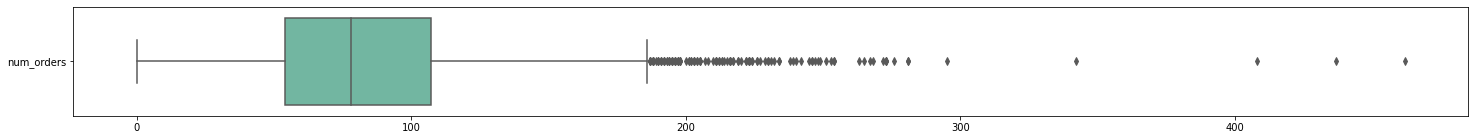

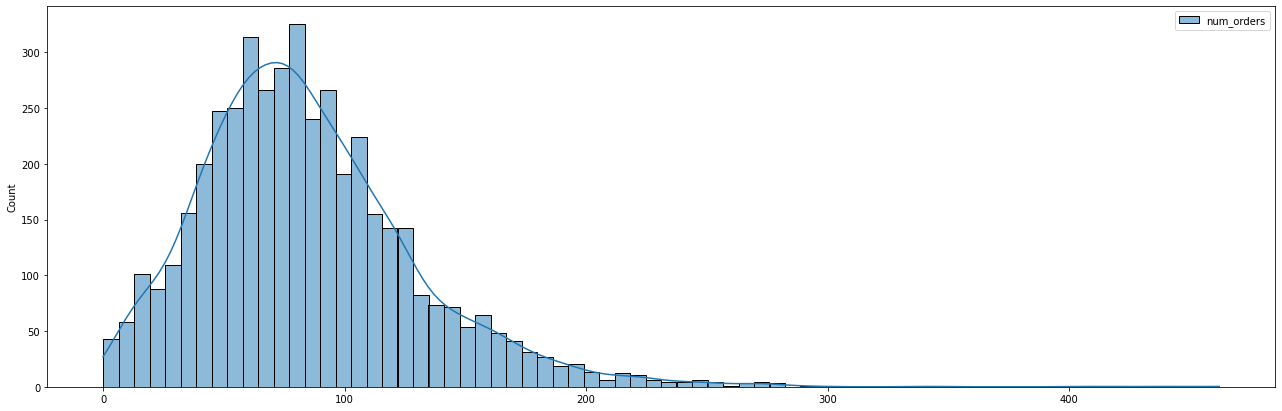

In [4]:
print(df.describe())

plt.figure(figsize=(25, 2))
sns.boxplot(data=df, orient='h', palette='Set2')
plt.show

plt.figure(figsize=(22, 7))
sns.histplot(data=df, kde = True)
plt.show

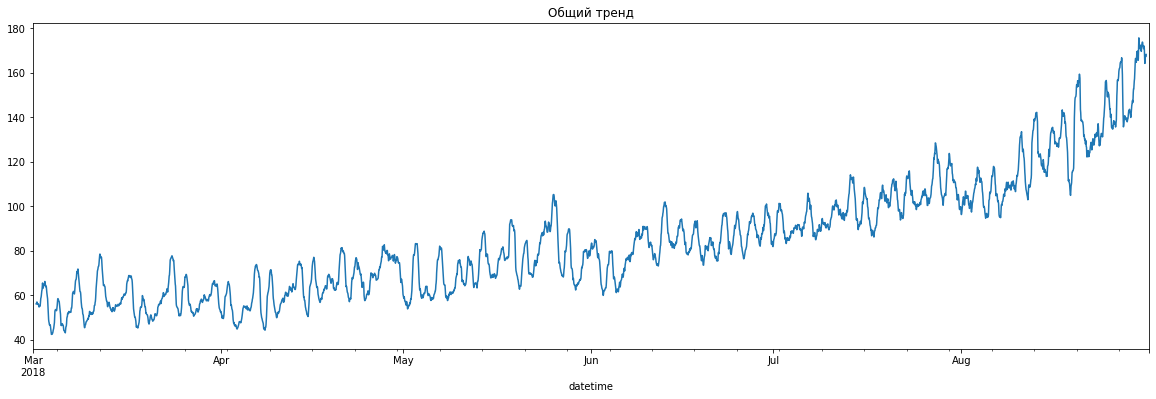

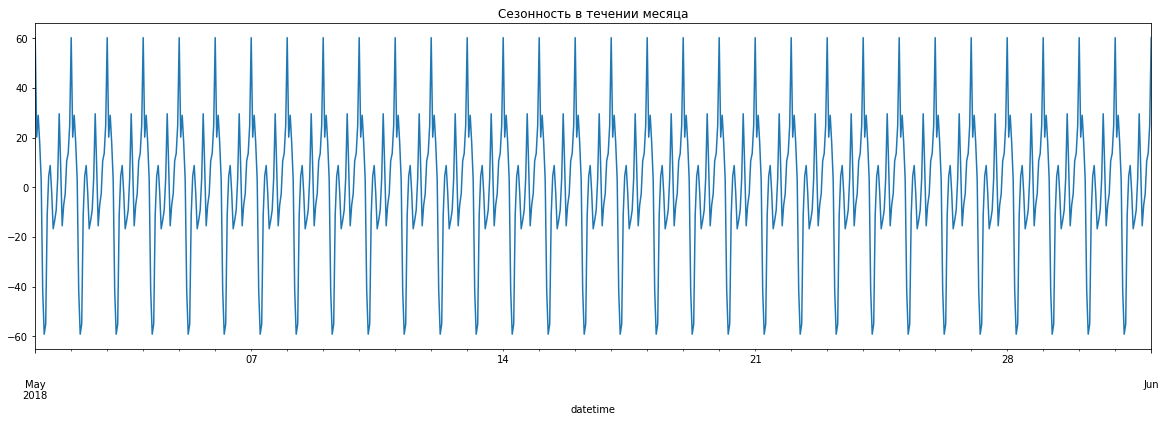

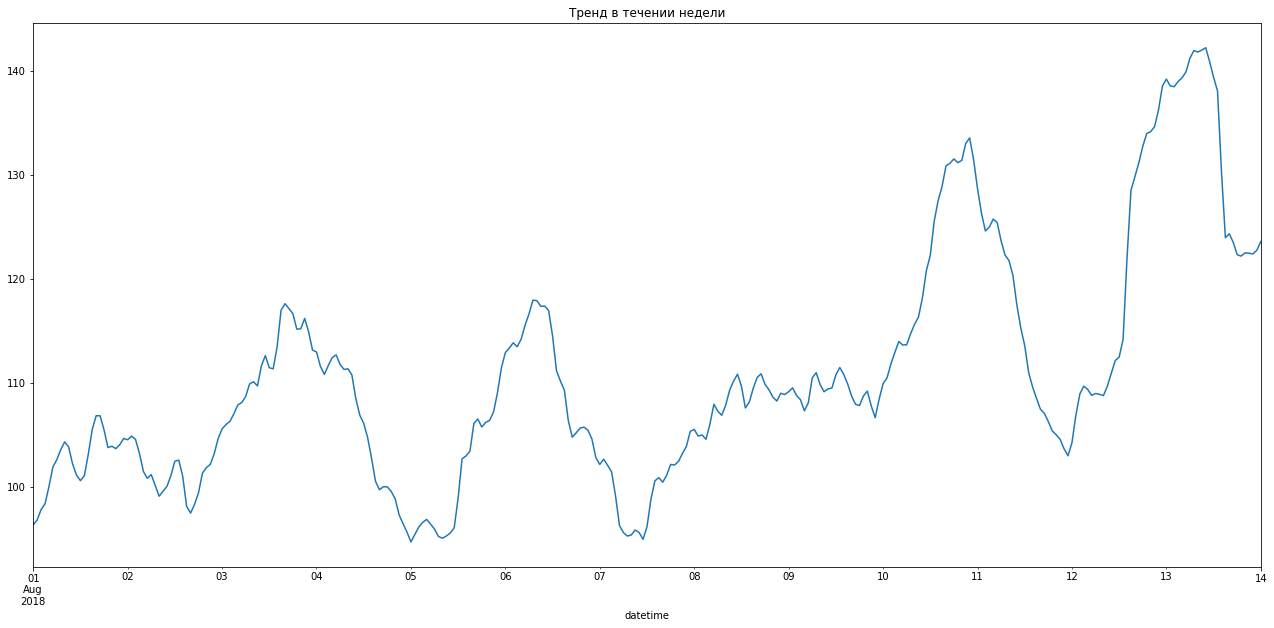

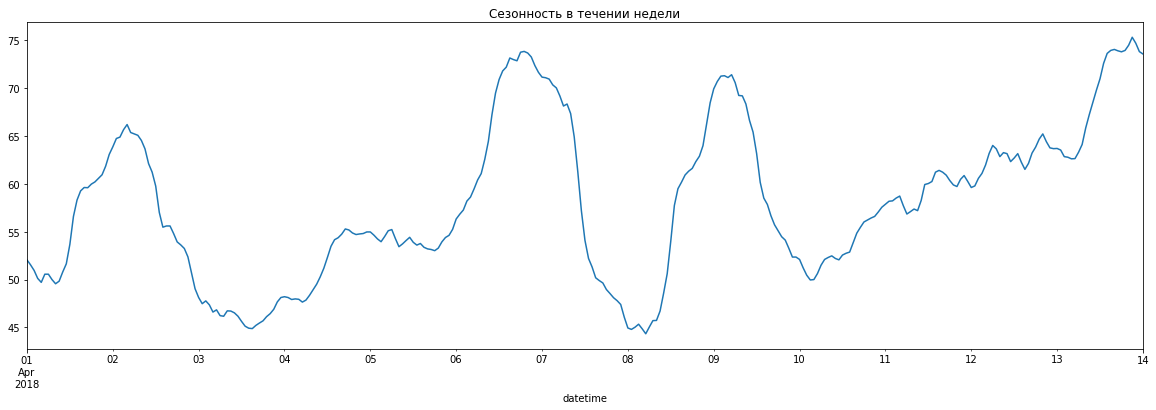

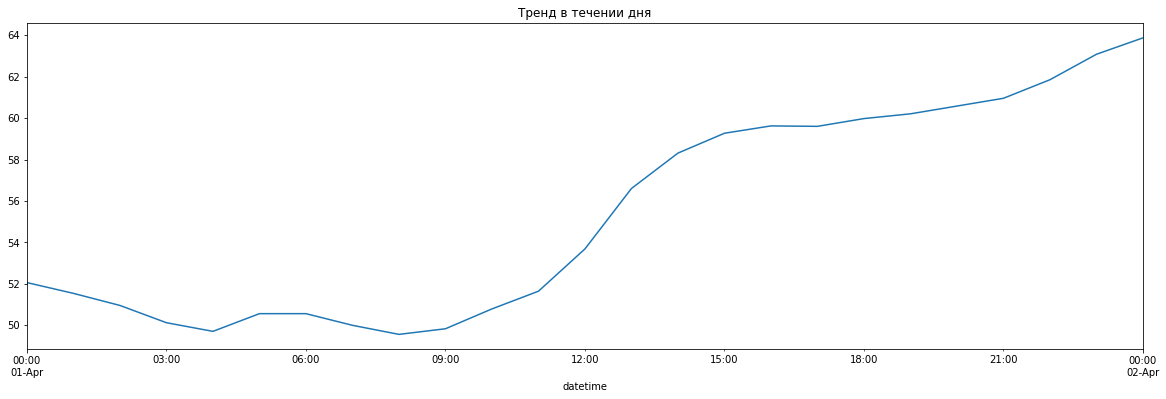

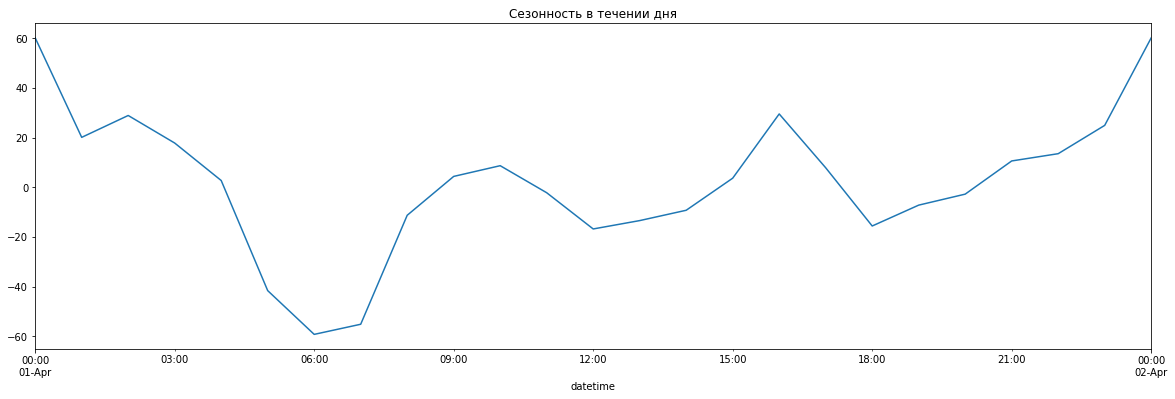

In [5]:
decomposed = seasonal_decompose(df)
   
# Общий тренд
plt.figure(figsize=(20, 6))
plt.title('Общий тренд')
decomposed.trend.plot(ax=plt.gca())
plt.show()

# Сезонность в течении месяца
plt.figure(figsize=(20, 6))
plt.title('Сезонность в течении месяца')
decomposed.seasonal['2018-05-01 00:00:00':'2018-06-01 00:00:00'].plot(ax=plt.gca())
plt.show()

# Тренд в течении недели
plt.figure(figsize=(22, 10))
plt.title('Тренд в течении недели')
decomposed.trend['2018-08-01 00:00:00':'2018-08-14 00:00:00'].plot(ax=plt.gca())
plt.show()

# Сезонность в течении недели
plt.figure(figsize=(20, 6))
plt.title('Сезонность в течении недели')
decomposed.trend['2018-04-01 00:00:00':'2018-04-14 00:00:00'].plot(ax=plt.gca())
plt.show()

# Тренд в течении дня
plt.figure(figsize=(20, 6))
plt.title('Тренд в течении дня')
decomposed.trend['2018-04-01 00:00:00':'2018-04-02 00:00:00'].plot(ax=plt.gca())
plt.show()

# Сезонность в течении дня
plt.figure(figsize=(20, 6))
plt.title('Сезонность в течении дня')
decomposed.seasonal['2018-04-01 00:00:00':'2018-04-02 00:00:00'].plot(ax=plt.gca())
plt.show()

### Вывод
Временной ряд нестационарный, потому что у него меняется среднее значение.  
При анализе графиков трендов и сезонности выявлены закономерности распределения вызовов по дням недели и времени суток.

## Обучение

### Создание новых признаков

In [6]:
# Датафрейм для контстантных моделей
df_c = df.copy()

# Создание новых признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(df, 2, 24)
df.dropna(inplace=True)
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,56.958333


In [7]:
# Разбивка на обучающую выборку и тестовую выборку
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

# Преобразование типа столбцов в категориальные
for item in ['dayofweek', 'hour']:
    df[item] = df[item].astype('category')
    

# Выделение в выборках признаков и целевого признака
train_target =  train['num_orders']
train_features = train.drop('num_orders', axis=1)
test_target =  test['num_orders']
test_features = test.drop('num_orders', axis=1)

# Разбивка обучающей выборки на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target,
                                                    test_size=0.1, shuffle=False, random_state=12345)

### Обучение модели CatBoostRegressor

In [8]:
%%time
# Модель CatBoostRegressor без оптимизации гиперпараметров
                                                   
train_pool = Pool(train_features, train_target , cat_features=[0, 1])
test_pool = Pool(test_features, test_target, cat_features=[0, 1]) 

model_cat = CatBoostRegressor(logging_level='Silent', random_state=12345)
model_cat.fit(train_pool)

CPU times: total: 51.3 s
Wall time: 26.4 s


In [9]:
# Подготовка гиперпареметров для Optuna

def objective(trial):
    train_pool1 = Pool(X_train, y_train, cat_features=[0, 1])
    test_pool1 = Pool(X_test, y_test, cat_features=[0, 1]) 


    params = {"subsample": trial.suggest_float("subsample", 0.5, 0.99),
                     'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
                     "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.99),
                     "random_strength": trial.suggest_int("random_strength", 1, 10, step=1),
                     "max_depth": trial.suggest_int("max_depth", 6, 10, step=1),
                     "n_estimators": trial.suggest_int("n_estimators", 100, 2500, step=1),
                     'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1),
                     'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
                     'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
                     'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15)}

    cbregressor = CatBoostRegressor(**params, 
                                       random_state=12345,
                                       loss_function='RMSE', 
                                       eval_metric='RMSE', 
                                       one_hot_max_size=0,
                                       boost_from_average=True,
                                       logging_level='Silent')
    
    cat_optuna = cbregressor.fit(train_pool1, eval_set=test_pool1, verbose=False, early_stopping_rounds=10)

    
    pred = cat_optuna.predict(X_test)
    
    RMSE = mean_squared_error(y_test, pred, squared=False)
    return RMSE

In [10]:
%%time

# Создание задания
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study = optuna.create_study(direction="minimize", study_name="Catboost Optuna")
study.optimize(objective, n_trials=50, n_jobs=-1)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already speci

CPU times: total: 32min 59s
Wall time: 2min 26s


In [11]:
%%time
# Создание и обучение модели с подобранными гиперпараметрами
cb_params = study.best_params
model_cb = CatBoostRegressor(**cb_params)
model_cb.fit(train_pool, eval_set=test_pool, verbose=False, early_stopping_rounds=10)

CPU times: total: 10.6 s
Wall time: 3.66 s


### Обучение модели LGBMRegressor

In [12]:
%%time

# Модель LGBMRegressor без оптимизации гиперпараметров
lgb_train = lgb.Dataset(train_features, train_target)
lgb_eval = lgb.Dataset(test_features, test_target, reference=lgb_train)

# Параметры
params = {'task': 'train',
         'boosting_type': 'gbdt', 
         'metric': 'l2_root'}

# Вызов модели LightGBM и использование данных для обучения
model_lgb = lgb.train(params, lgb_train, num_boost_round=20,
                     valid_sets=lgb_eval, verbose_eval=0)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 5
[LightGBM] [Info] Start training from score 78.451417
CPU times: total: 500 ms
Wall time: 25 ms


In [13]:
# Подготовка гиперпареметров для Optuna

def objective(trial):
    params = {
        'objective': 'regression',
        'random_state': 12345,
        'verbose': -1,
        'metric': 'rmse', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth',3, 50),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 20000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)}
    
    model = LGBMRegressor(**params)      
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="rmse", early_stopping_rounds=300, verbose=False)
    preds = model.predict(X_test)
    
    # Финальная метрика RMSE
    rmse_lgbmr = mean_squared_error(y_test, preds, squared=False)    
    return rmse_lgbmr

In [14]:
%%time

# Создание задания
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5, n_jobs=-1)

# Просмотр финальных метрик
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

Number of finished trials: 5
Best trial: {'num_leaves': 683, 'colsample_bytree': 0.9976442051540391, 'reg_alpha': 2.2625169496121087, 'reg_lambda': 6.7018751014207325, 'max_depth': 46, 'learning_rate': 4.0718181691906094e-05, 'n_estimators': 19767, 'min_child_samples': 34, 'cat_smooth': 47}
Best score: 43.53860514477733
CPU times: total: 10min 4s
Wall time: 40.5 s


In [15]:
%%time

# Создание и обучение модели с подобранными гиперпараметрами
lgbmr_params = study.best_params
model_LGBMR = LGBMRegressor(**lgbmr_params)
model_LGBMR.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="rmse", early_stopping_rounds=300, verbose=False)

CPU times: total: 6min 53s
Wall time: 26.7 s


LGBMRegressor(cat_smooth=47, colsample_bytree=0.9976442051540391,
              learning_rate=4.0718181691906094e-05, max_depth=46,
              min_child_samples=34, n_estimators=19767, num_leaves=683,
              reg_alpha=2.2625169496121087, reg_lambda=6.7018751014207325)

### Обучение модели LinearRegression

In [16]:
# Применение One Hot Encoding для  категориальных признаков
df_lr = pd.get_dummies(df, columns=['dayofweek', 'hour'], drop_first=True)

train_lr, test_lr = train_test_split(df_lr, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

train_y =  train_lr['num_orders']
train_x = train_lr.drop('num_orders', axis=1)
test_y =  test_lr['num_orders']
test_x = test_lr.drop('num_orders', axis=1)

In [17]:
%%time
parametrs = [{'fit_intercept':[True, False], 'copy_X': [True, False], 'positive': [True, False]}]
model_lr = GridSearchCV(LinearRegression(), parametrs, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
model_lr.fit(train_x, train_y)

CPU times: total: 219 ms
Wall time: 4.15 s


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid=[{'copy_X': [True, False],
                          'fit_intercept': [True, False],
                          'positive': [True, False]}],
             scoring='neg_root_mean_squared_error')

## Тестирование

### Тестирование модели CatBoostRegressor

In [18]:
#  Модели CatBoostRegressor без подбора гиперпараметров
pred_cat = model_cat.predict(test_pool)
rmse_cat = mean_squared_error(test_target, pred_cat, squared=False)
print('RMSE = ','%.1f'% rmse_cat)

RMSE =  47.2


In [19]:
#  Модель CatBoostRegressor с подбором гиперпараметров
pred_cb = model_cb.predict(test_features)
rmse_cb = mean_squared_error(test_target, pred_cb, squared=False)
print('RMSE = ','%.1f'% rmse_cb)

RMSE =  41.4


### Тестирование модели LGBMRegressor

In [20]:
#  Модель  LGBMRegressor без подбора гиперпараметров
pred_lg = model_lgb.predict(test_features, num_iteration=model_lgb.best_iteration)
rmse_lgb = np.sqrt(mean_squared_error(pred_lg, test_target))
print('RMSE: ', '%.1f'% rmse_lgb)

RMSE:  51.3


In [21]:
#  Модель  LGBMRegressor с подбором гиперпараметров
pred_LGBMR = model_LGBMR.predict(test_features)
rmse_LGBMR = mean_squared_error(test_target, pred_LGBMR, squared=False)
print('RMSE =', '%.1f'% rmse_LGBMR)

RMSE = 71.3


### Тестирование модели LinearRegression

In [22]:
pred_lr = model_lr.predict(test_x)
rmse_lr = mean_squared_error(pred_lr, test_y, squared=False)
print("RMSE:", '%.1f'% rmse_lr)

RMSE: 42.3


### Проверка константных моделей

In [23]:
# Предсказание заменяется предыдущим значением
train_с, test_с = train_test_split(df_c, shuffle=False, test_size=0.1)
pred_previous = test_с.shift(fill_value=0)
pred_previous.iloc[0] = train_с.iloc[-1]
rmse_const = np.sqrt(mean_squared_error(pred_previous, test_с))
print('RMSE по  предыдущим значению:', '%.1f'% rmse_const)

# Предсказание заменяется медианным значением
pred_median = np.ones(test_с.shape) * train_с['num_orders'].median()
rmse_med = np.sqrt(mean_squared_error(pred_median, test_с['num_orders']))
print("RMSE по среднему значению вызовов в день:", '%.1f'% rmse_med)

RMSE по  предыдущим значению: 58.9
RMSE по среднему значению вызовов в день: 87.2


### Построение графиков

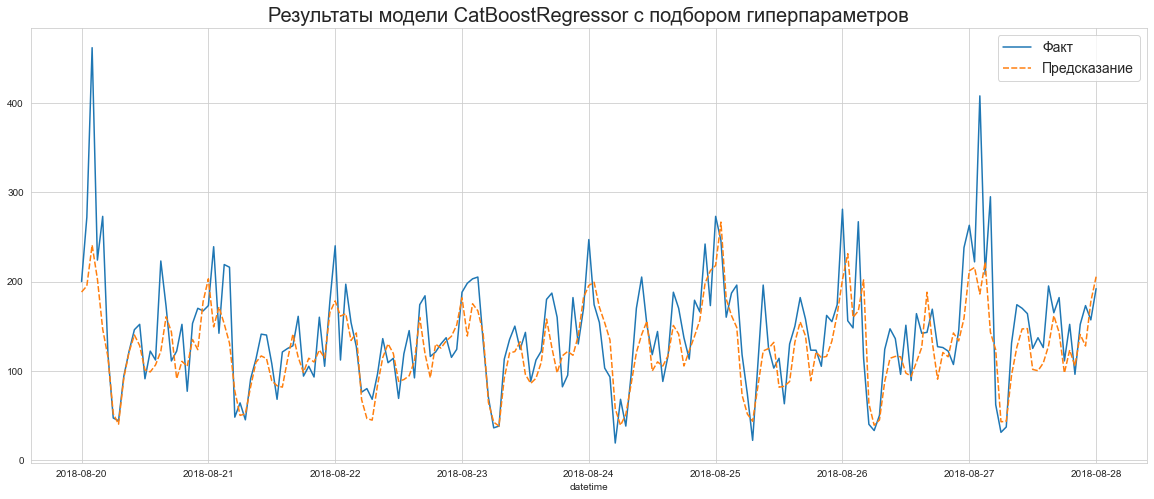

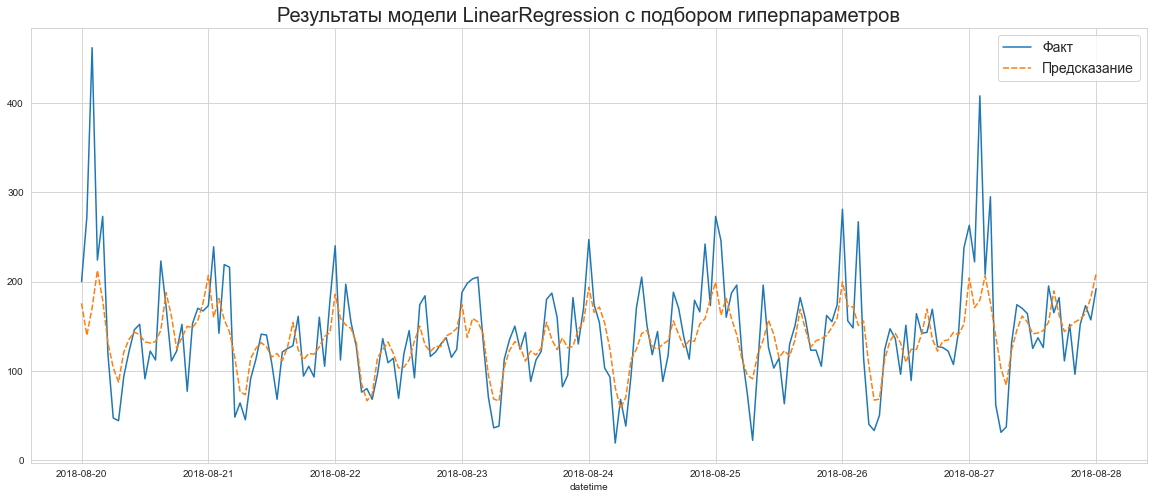

In [24]:
#  Модель CatBoostRegressor с подбором гиперпараметров
graf = pd.DataFrame({'target':test_target, 'pred':pred_cb})
graf7day = graf['2018-08-20 00:00:00':'2018-08-28 00:00:00']
plt.figure(figsize=(20, 8))
sns.set_style('whitegrid')
sns.lineplot(data=graf7day)
plt.title('Результаты модели CatBoostRegressor с подбором гиперпараметров', fontsize=20)
plt.legend(labels=["Факт","Предсказание"], fontsize=14)
plt.show()

#  Модель LinearRegression
graf = pd.DataFrame({'target':test_target, 'pred':pred_lr})
graf7day = graf['2018-08-20 00:00:00':'2018-08-28 00:00:00']
plt.figure(figsize=(20, 8))
sns.set_style('whitegrid')
sns.lineplot(data=graf7day)
plt.title('Результаты модели LinearRegression с подбором гиперпараметров', fontsize=20)
plt.legend(labels=["Факт","Предсказание"], fontsize=14)
plt.show()

### Вывод
Для прогнозирование заказов такси на следующий день бы ло проведен анализ заказов такси за период с апреля по сентябрь 2018 г.
При анализе заказов были обнаружены закономерности количесва вызовов на двух интервалах времени - в течении недели и в течении дня. В датасете были сформированы дополнительные признаки. Дл предказания  вызовов были обучены три модели: CatBoostRegressor, LGBMRegresso, LinearRegression. Наиболе точное предказание у CatBoostRegressor RMSE =  41.4 , затем у LinearRegression RMSE =  42.3 и LGBMRegressor RMSE =  51.3. Самая высокая скорость обучения у модели LinearRegression самая низкая у модели CatBoostRegressor.  
При анализе графиков предсказание / факт выявлено, что  самые большие ошибки предсказний возникают на пиковых максимальных значениях вызовов за час. Это объясняется тем что модель обученная на исторических данных не может предсказать случайные "пики" количества вызовов.
Обученные модели были проверены на адекватность константной моделью.